# Milestone 2

## Time Series Modelling

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df1=pd.read_excel(r'C:\Users\abhig\Documents\Springboard\FutureCart\Datasets\ProductA.xlsx')
df2=pd.read_excel(r'C:\Users\abhig\Documents\Springboard\FutureCart\Datasets\ProductA_google_clicks.xlsx')
df3=pd.read_excel(r'C:\Users\abhig\Documents\Springboard\FutureCart\Datasets\ProductA_fb_impressions.xlsx')

new_df1=pd.merge(df1, df2, on='Day Index', how='left')

df=pd.merge(new_df1, df3, on='Day Index', how='left')# datset combining all 3 datasets

In [3]:
df.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678


In [6]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_clean = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

print("Original DataFrame:")
print(df)
print("\nDataFrame after removing outliers:")
print(df_clean)

Original DataFrame:
     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
4   2021-12-05        33     451          678
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218
208 2022-06-27        16     106         1311
209 2022-06-28        13     109          885
210 2022-06-29        16      60         1000
211 2022-06-30         8      65          875

[212 rows x 4 columns]

DataFrame after removing outliers:
     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
5   2021-12-06        12     429          995
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218


In [7]:
df=df_clean
df.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
5,2021-12-06,12,429,995


df is the final data with no outliers and missing values

<Axes: >

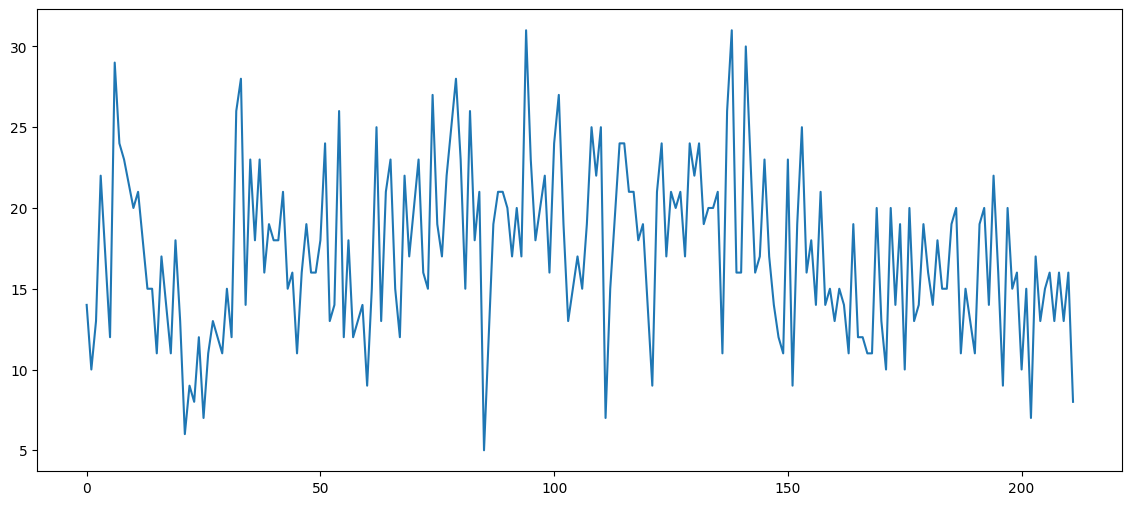

In [7]:
df['Quantity'].plot(figsize=(14,6))

## Stationarity Check

In [71]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Quantity']) #storing the test results in result

print('ADF Statistic:', result[0])  # Test statistic; helps determine stationarity
print('p-value:', result[1])       # p-value; used to decide on rejecting the null hypothesis
#print('Critical Values:', result[4])  # Critical values for different significance levels

for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

print('Output: ')
if result[1] < 0.05:
    print("    Reject the null hypothesis: The series is stationary.")
else:
    print("    Fail to reject the null hypothesis: The series is non-stationary.")

ADF Statistic: -4.516446455668561
p-value: 0.00018361360605353083
Critical Value (1%): -3.462980134086401
Critical Value (5%): -2.875885461947131
Critical Value (10%): -2.5744164898444515
Output: 
    Reject the null hypothesis: The series is stationary.


## Plotting ACF and PACF

Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots are essential tools for analyzing dependencies in a time series, especially when identifying the parameters for ARIMA models or understanding the structure of your data.

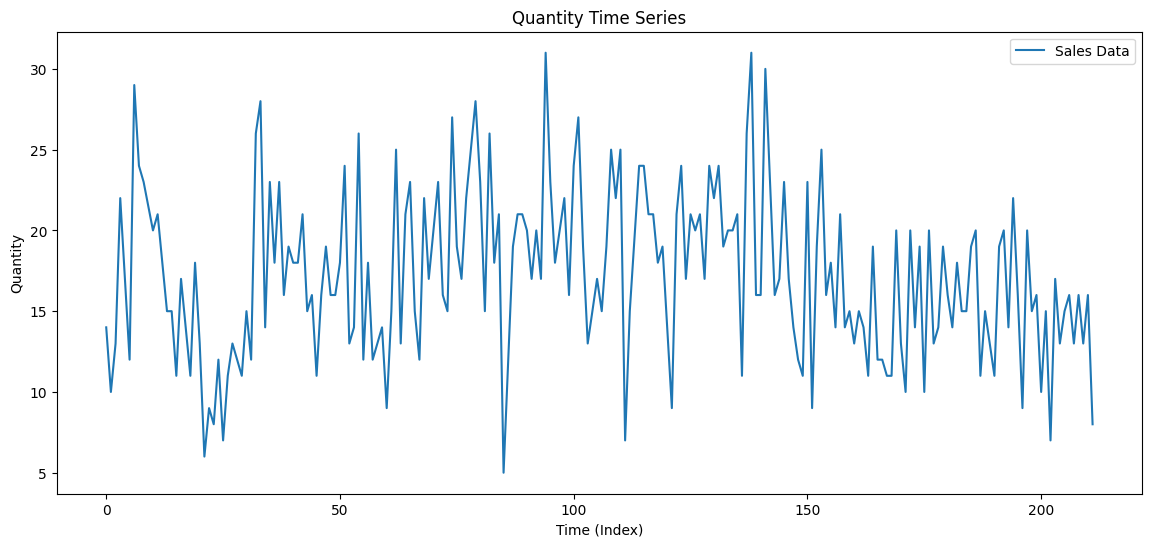

<Figure size 1000x600 with 0 Axes>

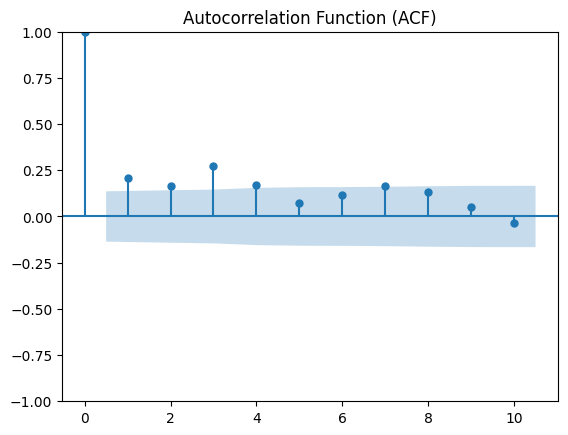

<Figure size 1000x600 with 0 Axes>

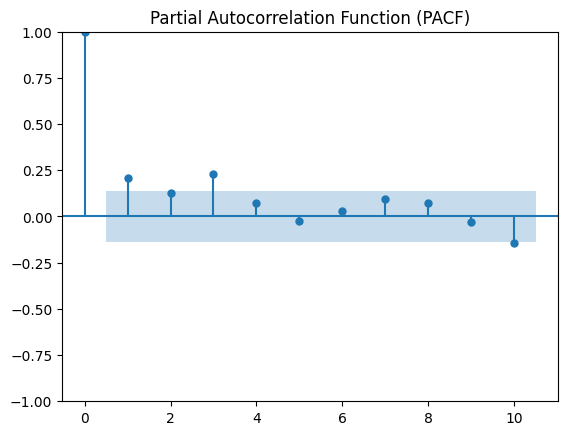

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))
plt.plot(df['Quantity'], label='Sales Data')
plt.title('Quantity Time Series')
plt.xlabel('Time (Index)')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(10, 6))
plot_acf(df['Quantity'], lags=10, title="Autocorrelation Function (ACF)")
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plt.figure(figsize=(10, 6))
plot_pacf(df['Quantity'], lags=10, title="Partial Autocorrelation Function (PACF)", method='ywm')
plt.show()

**Key Observations from the ACF Plot:**
1.The first lag (lag 1) shows a significant spike, indicating a strong correlation with its immediate past value.

-Subsequent lags decay gradually and remain within the confidence interval (the blue shaded area).

-There is no sudden cutoff after a specific lag.

**Key Observations from the PACF Plot:**
1. The first lag (lag 1) shows a significant spike, indicating a strong correlation with the immediate past value.
2. Subsequent lags show no significant spikes and remain within the confidence interval (the blue shaded area).
3. There is a sudden cutoff after lag 1, which means the partial correlation becomes insignificant for higher lags.


## Train Test Split

The process of splitting your time series data into training and testing subsets to evaluate model performance.It is to ensure the model is evaluated on unseen data (test set), simulating real-world forecasting scenarios.

In [10]:
# Sort the dataset by the date column
data = df.sort_values(by='Day Index')  

# Define train-test split 
train_size = int(0.7 * len(data))  # 80% for training

# Split the data
train = data.iloc[:train_size]  # First 80% rows - train
test = data.iloc[train_size:]   # Remaining 20% rows - test

print(f"Train size: {len(train)}, Test size: {len(test)}")

# Define the train and test datasets for the exogenous variables (independent variables)
train_exog = data[['Impressions', 'Clicks']][:train_size]
test_exog =  data[['Impressions', 'Clicks']][train_size:]


Train size: 144, Test size: 63


In [15]:
train.head()

,Day Index,Quantity,Clicks,Impressions,rolling_mean,rolling_std
0,2021-12-01,14,445,620,NaN,NaN
1,2021-12-02,10,433,890,NaN,NaN
2,2021-12-03,13,424,851,NaN,NaN
3,2021-12-04,22,427,881,NaN,NaN
5,2021-12-06,12,429,995,NaN,NaN


In [16]:
test.head()

,Day Index,Quantity,Clicks,Impressions,rolling_mean,rolling_std
149,2022-04-29,11,131,1323,19.083333,6.761634
150,2022-04-30,23,282,1394,18.833333,6.534292
151,2022-05-01,9,274,1834,17.000000,5.862051
152,2022-05-02,19,154,1906,17.250000,5.879471
153,2022-05-03,25,133,1743,18.000000,6.266796


## Modelling

## AR Model

C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib

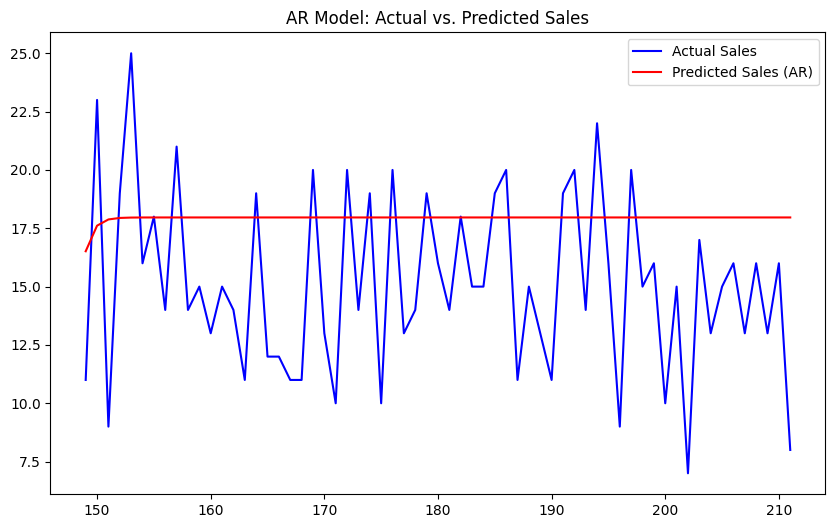

Mean Absolute Error (MAE): 4.029659361274381
Mean Squared Error (MSE): 22.684517328664562
Root Mean Squared Error (RMSE): 4.76282661123251
Mean Percentage Difference: 32.15971505708574%


In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit the ARIMA model (AR=0, I=0, MA=1)
ar_model = ARIMA(train['Quantity'], order=(1, 0, 0))
ar_fitted_model = ar_model.fit()

# Predict on the test data
predictions = ar_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (AR)', color='red')
plt.title('AR Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for AR Model:**
1. The model shows moderate performance, with an average error (MAE) of 4.03 and a high relative error (32.16%).
2. The relatively high RMSE suggests that outliers or larger deviations may be affecting predictions.

## MA Model

C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib

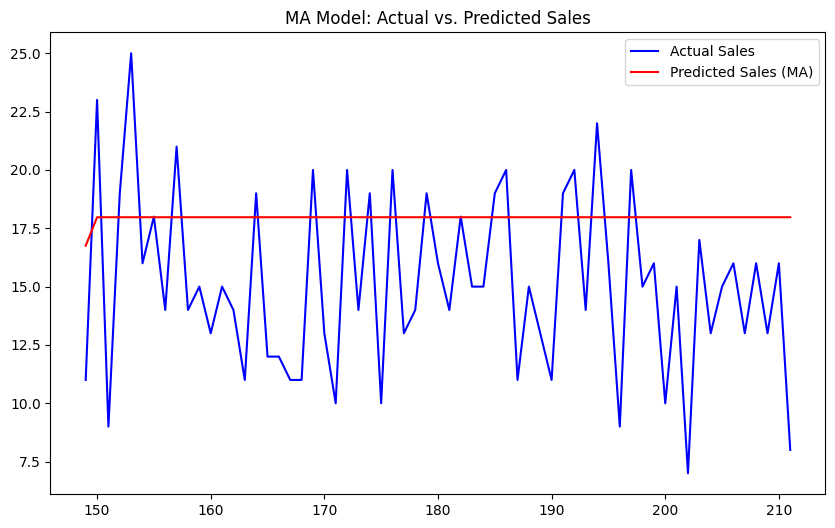

Mean Absolute Error (MAE): 4.032763000191929
Mean Squared Error (MSE): 22.74395996448145
Root Mean Squared Error (RMSE): 4.769062797288525
Mean Percentage Difference: 32.197493017965435%


In [14]:
# Fit the ARIMA model (AR=0, I=0, MA=1)
ma_model = ARIMA(train['Quantity'], order=(0, 0, 1))
ma_fitted_model = ma_model.fit()

# Predict on the test data
predictions = ma_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (MA)', color='red')
plt.title('MA Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for the MA Model:**
1. The MA model's slightly higher MSE and RMSE suggest it may not handle large deviations as effectively as the AR model in this case.

## ARIMA MODEL

C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib

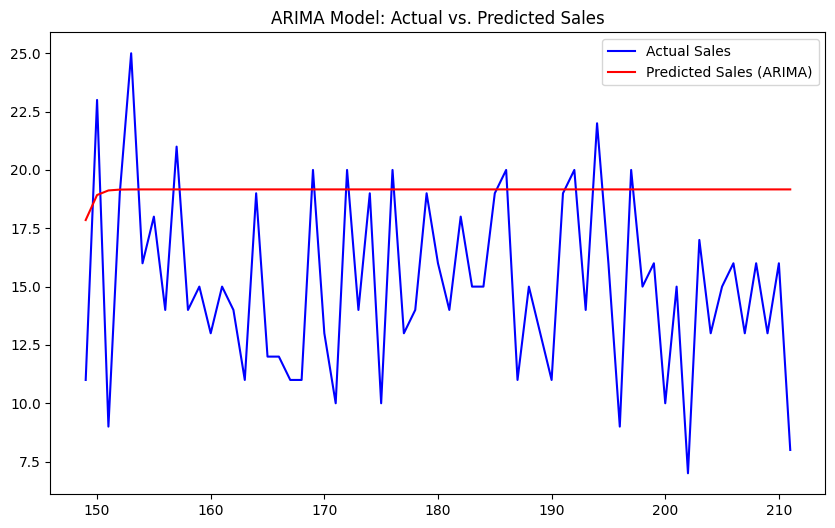

Mean Absolute Error (MAE): 4.650972430080794
Mean Squared Error (MSE): 30.941893452909827
Root Mean Squared Error (RMSE): 5.562543793347593
Mean Percentage Difference: 37.47710499178331%


In [13]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arima_model = ARIMA(train['Quantity'], order=(1, 1, 1))
arima_fitted_model = arima_model.fit()

# Predict on the test data
predictions = arima_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMA)', color='red')
plt.title('ARIMA Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights from ARIMA:**
1. MAE, MSE, RMSE: ARIMA performs worse than AR and MA models across all these metrics, with higher absolute, squared, and root errors.
2. Mean Percentage Difference: ARIMA also has a significantly higher percentage difference, indicating poorer relative performance.


## SARIMA MODEL

C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

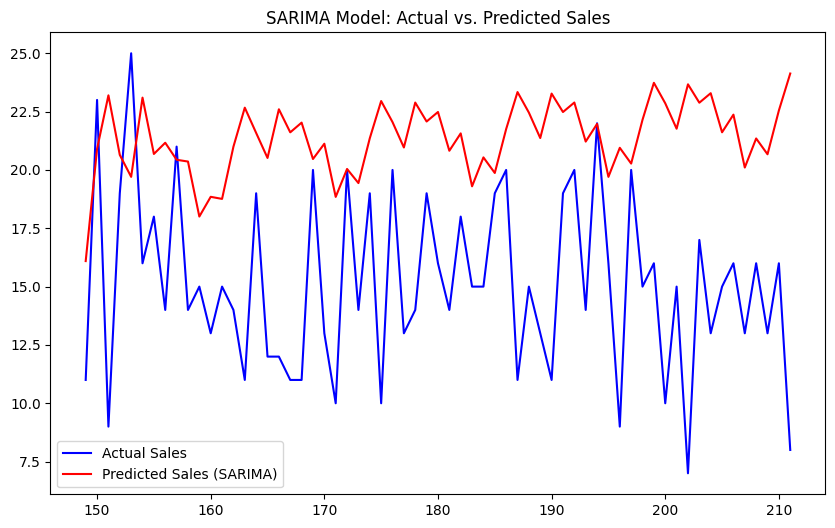

Mean Absolute Error (MAE): 6.499570305915901
Mean Squared Error (MSE): 58.12189397721083
Root Mean Squared Error (RMSE): 7.623771637267923
Mean Percentage Difference: 51.40288134164106%


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarima_model = SARIMAX(train['Quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fitted_model = sarima_model.fit()

# Predict on the test data
predictions = sarima_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMA)', color='red')
plt.title('SARIMA Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


Very poor performance by SARIMA.

## ARIMAX MODEL

C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib

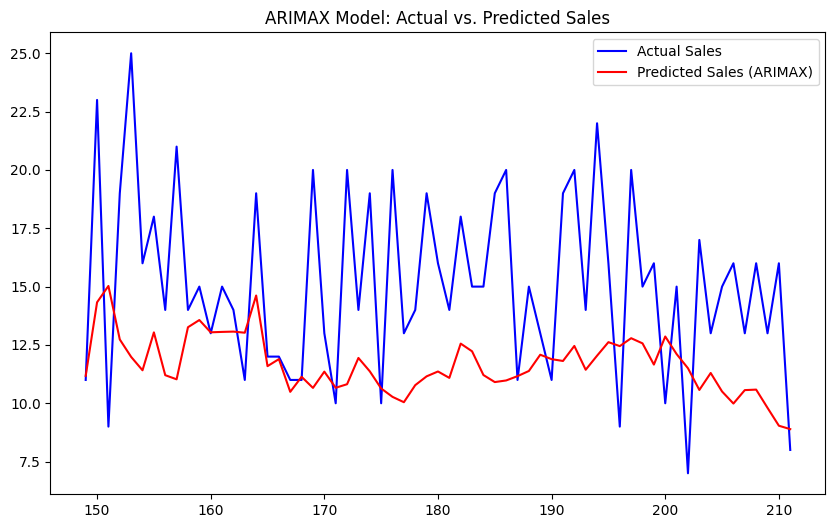

Mean Absolute Error (MAE): 4.160911321208081
Mean Squared Error (MSE): 27.09042132470047
Root Mean Squared Error (RMSE): 5.204845946298552
Mean Percentage Difference: 25.35791245877169%


In [46]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arimax_model = ARIMA(train['Quantity'], order=(1, 1, 1), exog=train_exog)
arimax_fitted_model = arimax_model.fit()

# Predict on the test data
predictions = arimax_fitted_model.forecast(steps=len(test), exog=test_exog)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMAX)', color='red')
plt.title('ARIMAX Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for ARIMAX Model:**

Although ARIMAX handles relative errors well, its absolute errors (MAE, MSE, RMSE) could be reduced further, potentially by refining model parameters or reassessing the exogenous variables.

## SARIMAX MODEL

C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Value

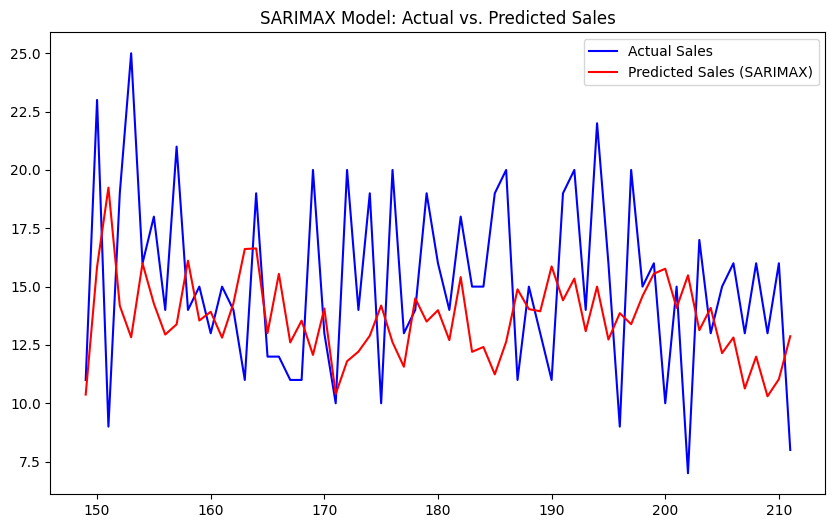

Mean Absolute Error (MAE): 3.6573521508511213
Mean Squared Error (MSE): 20.953705626301968
Root Mean Squared Error (RMSE): 4.577521777807504
Mean Percentage Difference: 22.259742036827635%


In [47]:

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarimax_model = SARIMAX(train['Quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_exog)
sarimax_fitted_model = sarimax_model.fit()

# Predict on the test data
predictions = sarimax_fitted_model.forecast(steps=len(test), exog=test_exog)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMAX)', color='red')
plt.title('SARIMAX Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for SARIMAX Model:**
-  SARIMAX achieves the best results across all metrics, suggesting that both seasonal patterns and external variables play a critical role in improving accuracy.
-  Suggestions : Fine-tune seasonal (P, D, Q, m) and non-seasonal (p, d, q) parameters.

In [15]:
# Evaluation metrics before hyperparameter tuning
metrics_before = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [4.029659361274381, 4.032763000191929, 4.650972430080794, 6.499570305915901, 4.160911321208081, 3.6573521508511213],
    "RMSE": [4.76282661123251, 4.769062797288525, 5.562543793347593, 7.623771637267923, 5.204845946298552, 4.577521777807504],
    "MSE": [22.684517328664562, 22.74395996448145, 30.941893452909827, 58.12189397721083, 27.09042132470047, 20.953705626301968],
    "PD": [32.15971505708574, 32.197493017965435, 37.47710499178331, 51.40288134164106,  25.35791245877169, 22.259742036827635],
})
print("Metrics Before Tuning")
print(metrics_before)

Metrics Before Tuning
     Model       MAE      RMSE        MSE         PD
0       AR  4.029659  4.762827  22.684517  32.159715
1       MA  4.032763  4.769063  22.743960  32.197493
2    ARIMA  4.650972  5.562544  30.941893  37.477105
3   SARIMA  6.499570  7.623772  58.121894  51.402881
4   ARIMAX  4.160911  5.204846  27.090421  25.357912
5  SARIMAX  3.657352  4.577522  20.953706  22.259742


The SARIMAX model consistently outperforms all others, achieving the lowest MAE, RMSE, MSE, and percentage error, thanks to its ability to account for seasonality and exogenous variables. While simpler models like AR and MA perform well for basic datasets, SARIMAX’s comprehensive approach makes it the best choice. Further fine-tuning of seasonal and exogenous parameters can enhance its accuracy even more.

In [37]:
# Function to plot residuals
def plot_residuals(model_fit, model_name):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title('Residual Plot')
    plt.legend()
    plt.show()

## HYPERPARAMETER TUNING

## Hyperparameters for ARIMA

In [28]:
# ARIMA Hyperparameter Tuning
def objective_arima(trial):
    # Hyperparameters for ARIMA
    p = trial.suggest_int("p", 0, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 5)

    # Ensure train_series is univariate
    train_series = train['Quantity']  # Replace 'Quantity' with your target column name

    # Fit ARIMA model
    model = ARIMA(train_series, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast (adjust for your evaluation)
    predictions = model_fit.forecast(len(test))
    mse = mean_squared_error(test['Quantity'], predictions)  # Replace 'Quantity' as needed

    return mse

# Create Optuna study for ARIMA
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)
best_arima_params = study_arima.best_params

# Print best ARIMA parameters
print("Best ARIMA Parameters:", best_arima_params)

[I 2024-11-27 12:16:22,691] A new study created in memory with name: no-name-194fd5e5-3687-4c49-b720-5052545ac0cb
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs

Best ARIMA Parameters: {'p': 5, 'd': 2, 'q': 2}


C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

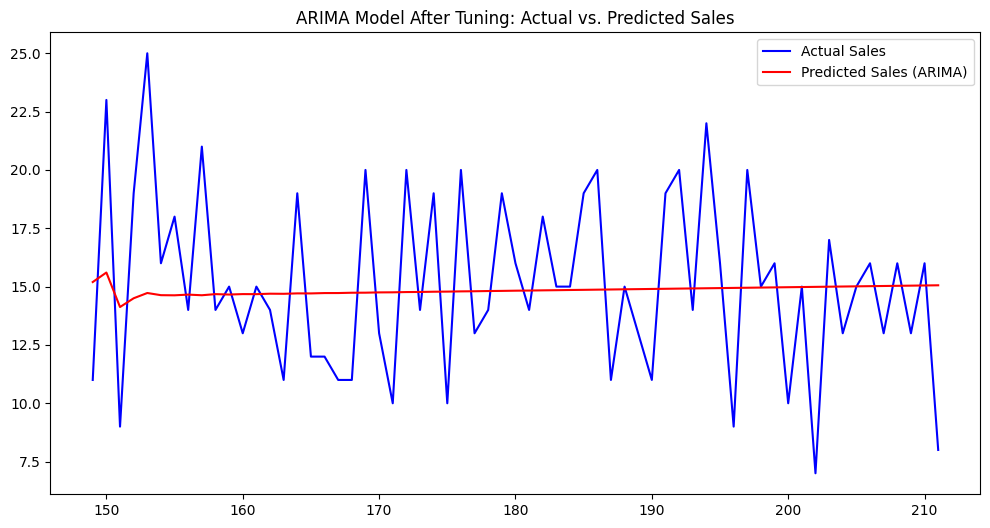

Mean Absolute Error (MAE): 3.0550530074347315
Mean Squared Error (MSE): 14.779297571952984
Root Mean Squared Error (RMSE): 3.84438520077697
Mean Percentage Difference: 21.857591095764565%


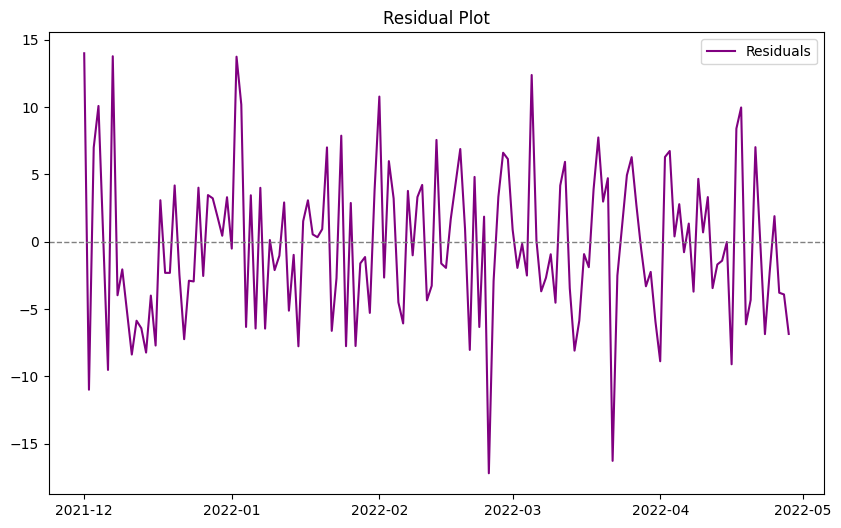

In [38]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arima_model_2 = ARIMA(train['Quantity'], order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_fitted_model_2 = arima_model_2.fit()

# Predict on the test data
predictions = arima_fitted_model_2.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMA)', color='red')
plt.title('ARIMA Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(arima_fitted_model_2, "Tuned ARIMA")

**Summary of Improvements After Tuning:**
- MAE has decreased from 4.65 to 3.06, showing a significant reduction in the average prediction error.
- MSE and RMSE both show considerable improvement, indicating the model now handles both small and large deviations more effectively.
- Mean Percentage Difference has dropped significantly, reflecting better relative accuracy in predictions.

**Residual Plot Observation:** The residuals fluctuate around zero but show some variability, suggesting the model is not fully capturing the patterns in the data.

## SARIMA Hyperparameter Tuning

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA Hyperparameter Tuning
def objective_sarima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 3)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 3)
    s = 12  # Fixed seasonal period

    train_series = train['Quantity']
    
    try:
        # Fit SARIMA with trial parameters
        model = SARIMAX(train_series,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Make predictions
        predictions = model_fit.forecast(steps=len(test))
        
        # Align predictions with the test series
        predictions = predictions.reset_index(drop=True) if hasattr(predictions, "reset_index") else predictions
        test_values = test['Quantity'].reset_index(drop=True) if hasattr(test['Quantity'], "reset_index") else test['Quantity']
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test_values, predictions))
        return rmse
    except Exception as e:
        return float("inf")  # Penalize trials that fail

# Create Optuna study for SARIMA
study_sarima = optuna.create_study(direction='minimize')
study_sarima.optimize(objective_sarima, n_trials=50)
best_sarima_params = study_sarima.best_params

# Print best SARIMA parameters
print("Best SARIMA Parameters:", best_sarima_params)

[I 2024-11-27 14:39:09,992] A new study created in memory with name: no-name-955b9ab4-469e-45b7-98c5-5ddf83c1f72c
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-p

Best SARIMA Parameters: {'p': 3, 'd': 2, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}


C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

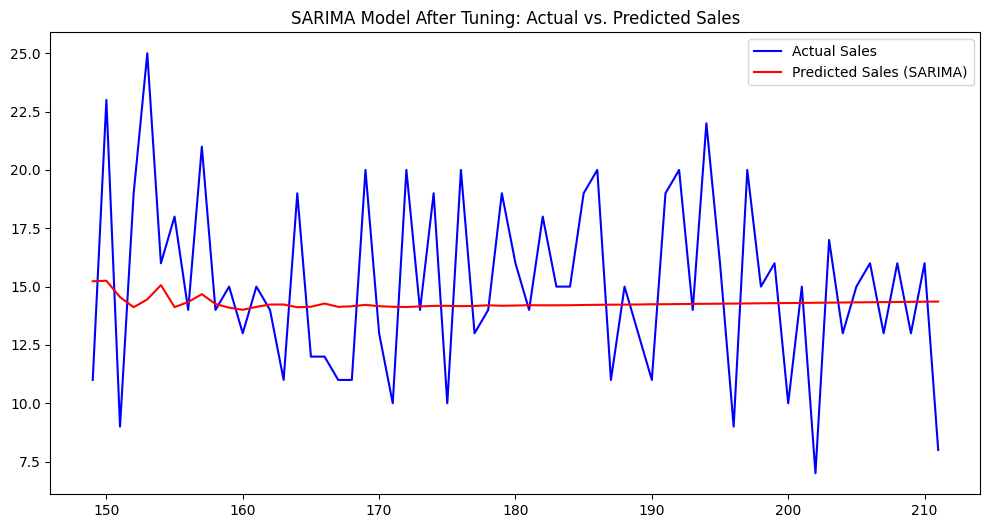

Mean Absolute Error (MAE): 3.107321506807049
Mean Squared Error (MSE): 15.35398635699663
Root Mean Squared Error (RMSE): 3.9184163072594305
Mean Percentage Difference: 21.51050091693585%


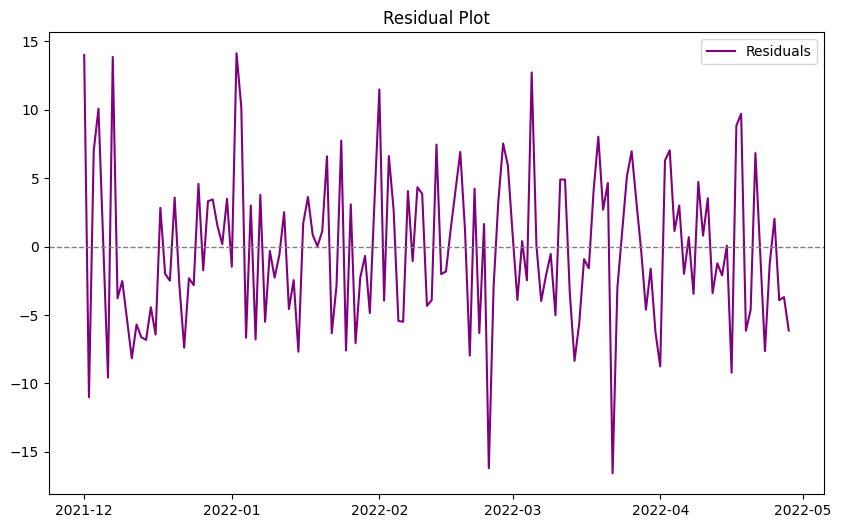

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarima_model_2 = SARIMAX(train_series,
                             order=(best_sarima_params['p'], best_sarima_params['d'], best_sarima_params['q']),
                             seasonal_order=(best_sarima_params['P'], best_sarima_params['D'], best_sarima_params['Q'], 12))
sarima_fitted_model_2 = sarima_model_2.fit()

# Predict on the test data
predictions = sarima_fitted_model_2.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMA)', color='red')
plt.title('SARIMA Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(sarima_fitted_model_2, "Tuned SARIMA")

**Summary of Improvements After Tuning:**
- MAE has decreased from 6.50 to 3.11, reflecting a significant reduction in the average error.
- MSE and RMSE both show substantial improvement, indicating that the tuned model is more stable and effective at handling both small and large errors.
- Mean Percentage Difference has dropped significantly from 51.40% to 21.51%, showing better relative accuracy in predictions.

**Residual Plot Explanation:** 
 Residuals are centered around zero and scattered randomly without seasonality or systematic patterns. However, the occasional spikes suggest some unmodeled variability or outliers in the data. 

In [53]:
train_exog.index = train.index
train_exog_aligned, _ = train_exog.align(train, join='inner', axis=0)
test_exog.index = test.index
test_exog_aligned, _ = test_exog.align(test, join='inner', axis=0)
print(train_exog_aligned.head())
print(test_exog_aligned.head())

            Impressions  Clicks
Day Index                      
2021-12-01          620     445
2021-12-02          890     433
2021-12-03          851     424
2021-12-04          881     427
2021-12-06          995     429
     Impressions  Clicks
149         1323     131
150         1394     282
151         1834     274
152         1906     154
153         1743     133


The align function is called to align train_exog with train. The join='inner' argument ensures that only the common indices between train_exog and train are kept. The axis=0 specifies that alignment is done row-wise (by index).

## ARIMAX HYPERPARAMETER TUNING

In [55]:
def objective_arimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    # Fit ARIMAX model with trial parameters
    model = ARIMA(train['Quantity'], order=(p, d, q), exog=train_exog_aligned)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=test_exog_aligned)

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Create Optuna study for ARIMAX
study_arimax = optuna.create_study(direction='minimize')
study_arimax.optimize(objective_arimax, n_trials=50)
best_arimax_params = study_arimax.best_params

# Print best ARIMAX parameters
print("Best ARIMAX Parameters:", best_arimax_params)


[I 2024-11-27 15:15:35,804] A new study created in memory with name: no-name-4301e8b0-e247-4618-a378-e0bf5d4fef45
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs

Best ARIMAX Parameters: {'p': 5, 'd': 1, 'q': 3}


C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

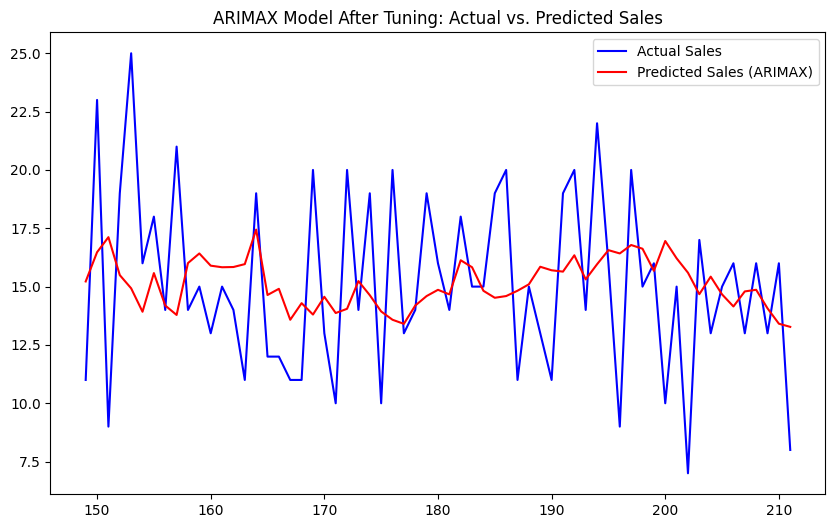

Mean Absolute Error (MAE): 3.157753169183577
Mean Squared Error (MSE): 15.542211416943946
Root Mean Squared Error (RMSE): 3.942361147452621
Mean Percentage Difference: 22.4886216325816%


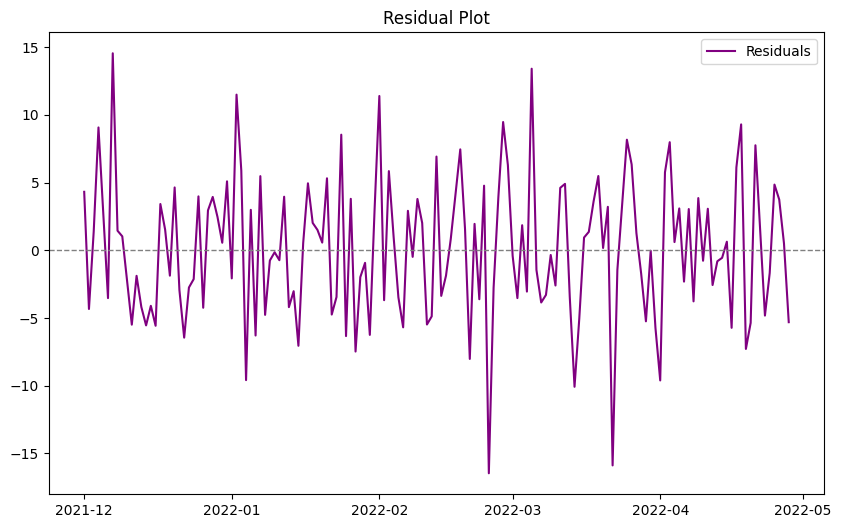

In [63]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arimax_model_2 = ARIMA(train['Quantity'],
                           order=(best_arimax_params['p'], best_arimax_params['d'], best_arimax_params['q']),
                           exog=train_exog_aligned)
arimax_fitted_model_2 = arimax_model_2.fit()

# Predict on the test data
predictions = arimax_fitted_model_2.forecast(steps=len(test), exog=test_exog_aligned)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMAX)', color='red')
plt.title('ARIMAX Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(arimax_fitted_model_2, "Tuned ARIMAX")

**Summary of Improvements After Tuning:**
- MAE has decreased from 4.16 to 3.16, indicating a notable reduction in the average error.
- MSE and RMSE both show significant improvement, reflecting better handling of both small and large deviations.
- Mean Percentage Difference has improved from 25.36% to 22.49%, indicating better relative accuracy.

**Residual Plot Explanation:**  The residuals are centered around zero, randomly scattered, and show no discernible seasonality or trends. Occasional outliers might indicate the presence of rare events or factors not included in the model. 

## SARIMAX HYPERPARAMETER TUNING

In [62]:
def objective_sarimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = 12  # 12 months fixed

    # Fit SARIMAX with trial parameters
    model = SARIMAX(train['Quantity'],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
    enforce_stationarity=True,
    enforce_invertibility=True,
                    exog=train_exog_aligned)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=test_exog_aligned)

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Create Optuna study for SARIMAX
study_sarimax = optuna.create_study(direction='minimize')
study_sarimax.optimize(objective_sarimax, n_trials=50)
best_sarimax_params = study_sarimax.best_params

# Print best SARIMAX parameters
print("Best SARIMAX Parameters:", best_sarimax_params)

[I 2024-11-27 15:27:12,741] A new study created in memory with name: no-name-87f770d1-9999-4b10-b8e5-b2218f66ac68
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\abhig\AppData\Local\Programs\Python\Python31

Best SARIMAX Parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 2}


C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\abhig\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

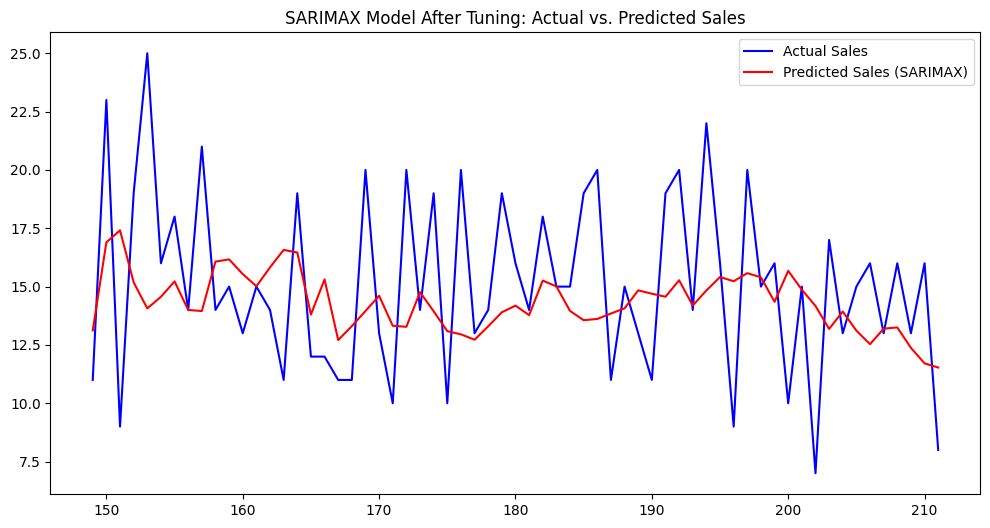

Mean Absolute Error (MAE): 3.1505748096200827
Mean Squared Error (MSE): 15.961719368999121
Root Mean Squared Error (RMSE): 3.995212055573411
Mean Percentage Difference: 22.10028853861372%


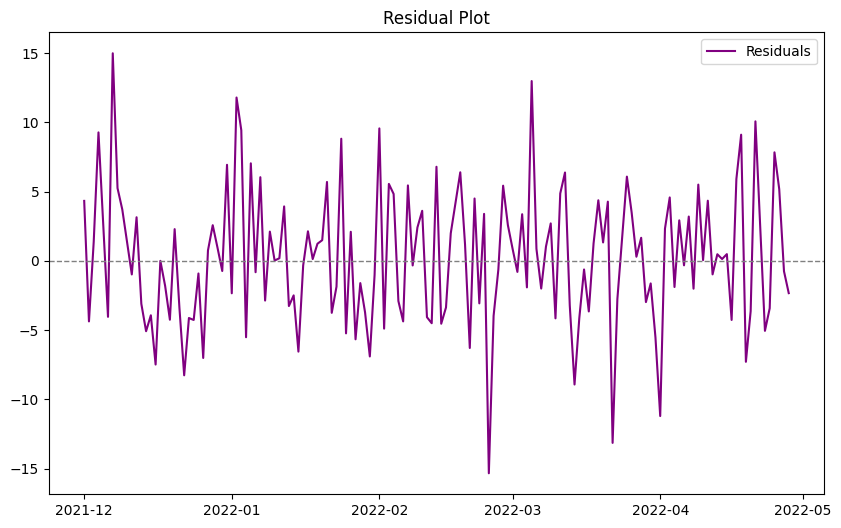

In [67]:

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarimax_model_2 = SARIMAX(train['Quantity'],
                              order=(best_sarimax_params['p'], best_sarimax_params['d'], best_sarimax_params['q']),
                              seasonal_order=(best_sarimax_params['P'], best_sarimax_params['D'], best_sarimax_params['Q'], 12),
                              exog=train_exog_aligned)
sarimax_fitted_model_2 = sarimax_model_2.fit()

# Predict on the test data
predictions = sarimax_fitted_model_2.forecast(steps=len(test), exog=test_exog_aligned)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMAX)', color='red')
plt.title('SARIMAX Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(sarimax_fitted_model_2, "Tuned SARIMAX")

**Summary of Improvements After Tuning:**
- MAE has decreased from 6.50 to 3.15, reflecting a significant improvement in average error.
- MSE and RMSE both show notable improvements, indicating the model now better handles both small and large errors.
- Mean Percentage Difference has improved from 51.40% to 22.10%, indicating much better relative accuracy in forecasts.


In [74]:
# Evaluation metrics after hyperparameter tuning
# Before tuning for AR, MA, ARIMA, SARIMA and after for ARIMAX, SARIMAX
metrics_after_tuning = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [4.029659361274381, 4.032763000191929, 4.650972430080794, 6.499570305915901, 3.157753169183577, 3.1505748096200827],
    "RMSE": [4.76282661123251, 4.769062797288525, 5.562543793347593, 7.623771637267923, 3.942361147452621,3.995212055573411],
    "MSE": [22.684517328664562, 22.74395996448145, 30.941893452909827, 58.12189397721083, 15.542211416943946, 15.961719368999121],
    "PD": [32.15971505708574, 32.197493017965435, 37.47710499178331, 51.40288134164106,  22.4886216325816, 22.10028853861372],
})
print("Metrics After Tuning:")
print(metrics_after_tuning)

Metrics After Tuning:
     Model       MAE      RMSE        MSE         PD
0       AR  4.029659  4.762827  22.684517  32.159715
1       MA  4.032763  4.769063  22.743960  32.197493
2    ARIMA  4.650972  5.562544  30.941893  37.477105
3   SARIMA  6.499570  7.623772  58.121894  51.402881
4   ARIMAX  3.157753  3.942361  15.542211  22.488622
5  SARIMAX  3.150575  3.995212  15.961719  22.100289


## Conclusion

After tuning, **ARIMAX** and **SARIMAX** perform the best in terms of minimizing error and improving prediction accuracy. Both models show significantly lower MAE, RMSE, and MSE values compared to simpler models like **AR** and **MA**, and also outperform **ARIMA** and **SARIMA**, especially in handling the relationship between the target variable and external influences.

- **SARIMAX** performs slightly better than **ARIMAX** in terms of percentage difference, but both models are highly effective when exogenous variables are included.
- **SARIMA**, despite having seasonal components, struggles with high errors, suggesting that the seasonal model alone isn't enough for good predictive accuracy without the added context of exogenous variables.

Thus, **SARIMAX** would be the preferred model for forecasting in cases where both seasonality and external variables influence the predictions.






